## TDA for time series

This notebook is for the topological data analysis (TDA) project as part of the Time-Domain Needles in Rubin's Haystack hackathon (April 17-19 2024, CfA).

The first idea is to create a distance matrix from the persistence diagrams of a set of time series and then learn a manifold from this and then identify outliers relative to the manifold.

We'll use the scikit-tda package to create persistence diagrams of 1D time series using a watershed (lower star or sublevelset filtration). 

In [47]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse

from ripser import ripser
import persim as ps

### Basics

Let's start with a simulated irregularly sampled time series - we'll use a lognormal distribution for the dts:

In [36]:
def genSimTS(mu, sigma, npts, func):
    mu, sigma, npts = np.log(5), 0.5, 500
    dt = np.random.lognormal(mu, sigma, npts)
    t = np.cumsum(dt)
    y = np.cos(2. * np.pi * t / 0.4)
    return np.array([t, y])

npts = 500

f = lambda x, per: np.cos(2. * np.pi * x / per)

ts1 = genSimTS(np.log(5), 0.5, npts, f)
ts2 = genSimTS(np.log(5), 0.5, npts, f)

<IPython.core.display.Javascript object>


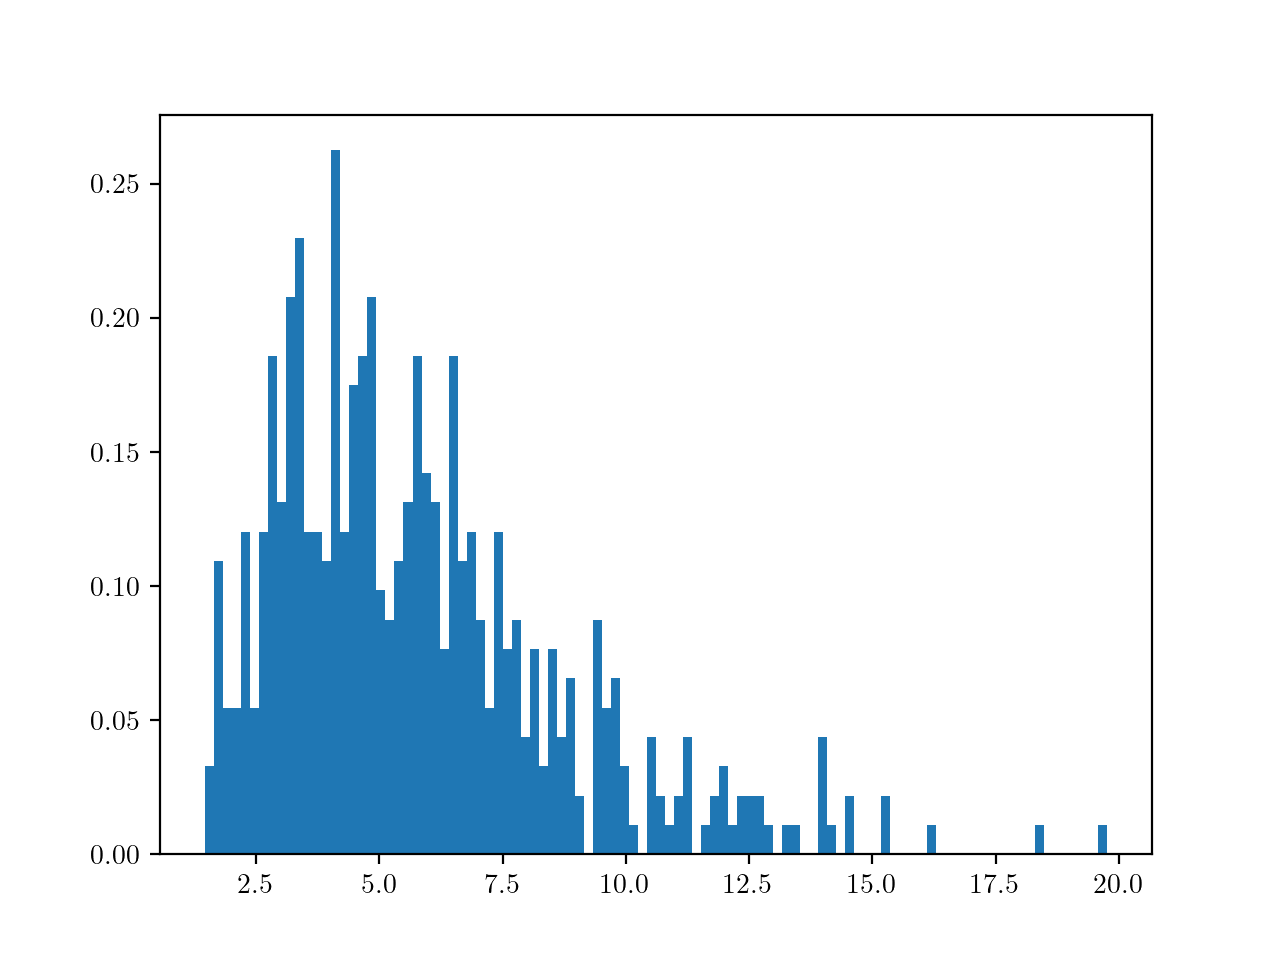

In [20]:
fig, ax = plt.subplots()
count, bins, _ = ax.hist(dt, 100, density = True, align = 'mid')
plt.show()

<IPython.core.display.Javascript object>


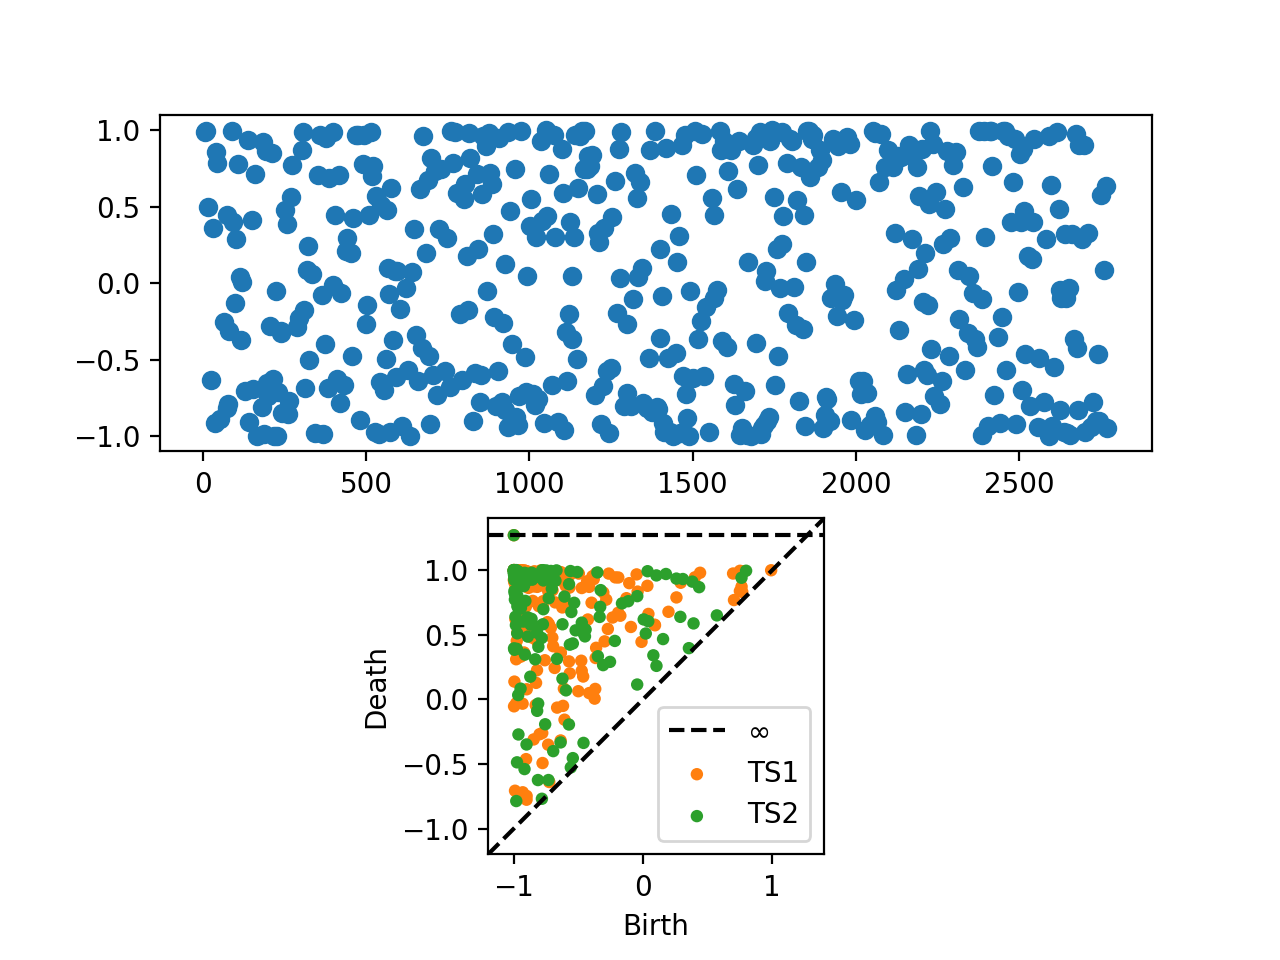

In [39]:
fig, ax = plt.subplots(2, 1)
ax[0].scatter(ts1[0], ts1[1])
ax[1].scatter(ts2[0], ts2[1])
plt.show()

Let's construct the persistence diagram for the time series:
Q. Does this only work for regularly sampled time series?

In [40]:
def getPD(ts):
    t, y = ts

    # Add edges between adjacent points in the time series 
    I = np.arange(npts - 1)
    J = np.arange(1, npts)
    V = np.maximum(y[0: -1], y[1::])

    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(npts))) 
    J = np.concatenate((J, np.arange(npts)))
    V = np.concatenate((V, y))

    # Create a sparse distance matrix representation
    D = sparse.coo_matrix((V, (I, J)), shape = (npts, npts)).tocsr()
    dgm0 = ripser(D, maxdim = 0, distance_matrix = True)['dgms'][0]
    dgm0 = dgm0[dgm0[:, 1] - dgm0[:, 0] > 1e-3, :]
    return dgm0

and plot it:

<IPython.core.display.Javascript object>


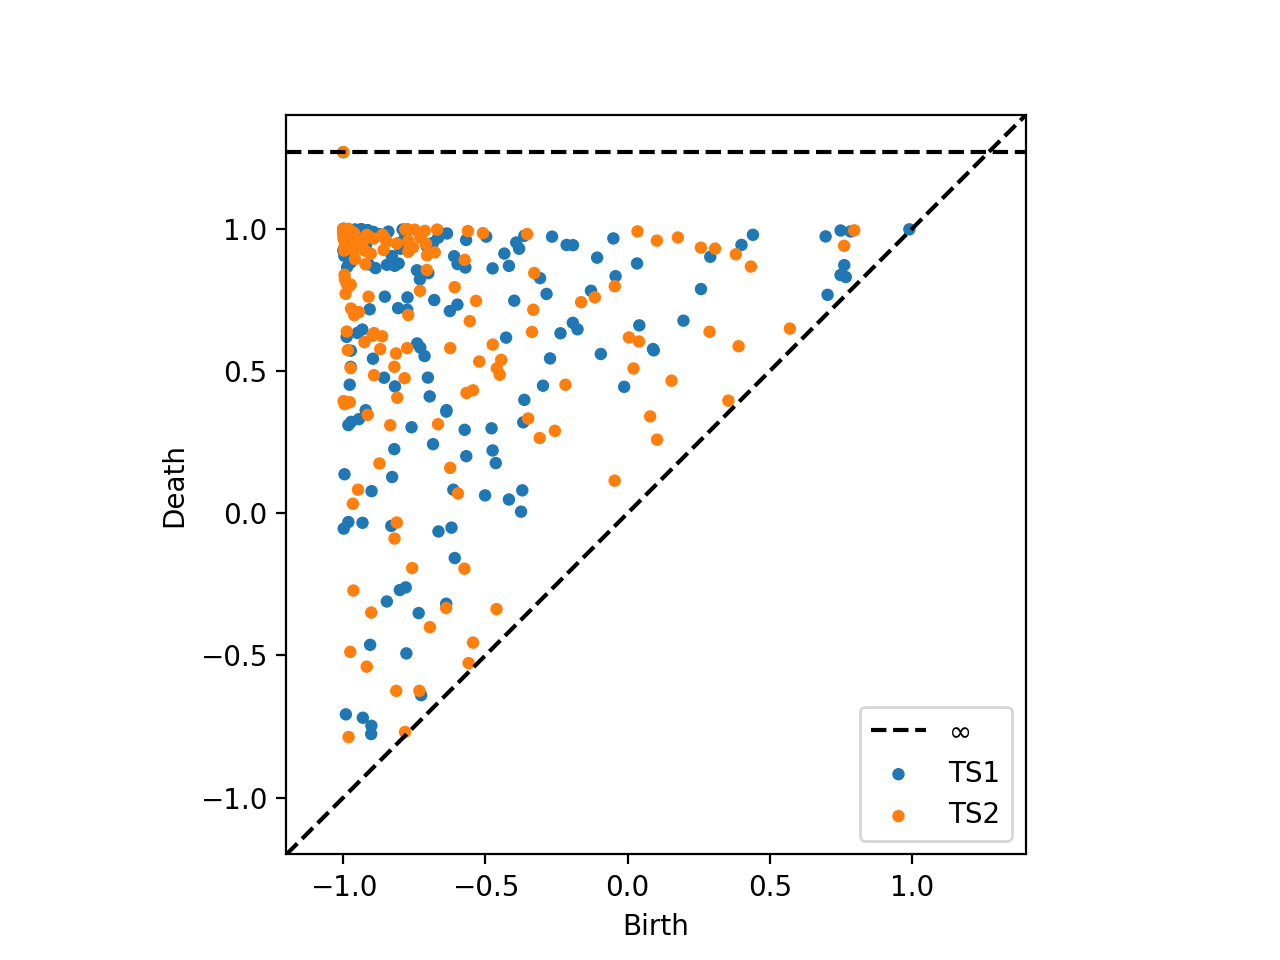

In [48]:
dgm1 = getPD(ts1)
dgm2 = getPD(ts2)

fig, ax = plt.subplots()
ps.plot_diagrams([dgm1, dgm2], labels = ['TS1', 'TS2'], show = True)

Chen et al. (2021) provide fast (O(n)) approximation algorithms for the 1-Wasserstein distance between PDs. Alternatively, we can use the various distances defined in the persim package: Wasserstein, Bottleneck, Sliced Wasserstein, and continuous heat kernel. 
(But does the bottleneck distance requires that there are equal numbers of points in the two PDs?)

In [56]:
dgm1, dgm2 = dgm1[:-1], dgm2[:-1]

print(f"Wasserstein: {ps.wasserstein(dgm1[:-1], dgm2)}")
print(f"Bottleneck: {ps.bottleneck(dgm1, dgm2)}")
print(f"Sliced Wasserstein: {ps.sliced_wasserstein(dgm1, dgm2, M = 50)}")
print(f"Heat: {ps.heat(dgm1, dgm2)}")

Wasserstein: 17.031558748354588
Bottleneck: 0.24036851897835732
Sliced Wasserstein: 10.035681279151706
Heat: 1.5137139830308608


### A set of time series